In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/DLSC/projectB/heat/'


Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jul 20 21:11:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-2), x.size(-1) // 2 + 1, dtype=torch.cfloat,
                             device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x


class FNO2d(nn.Module):
    def __init__(self, fno_architecture, device=None, padding_frac=1 / 4):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution
        output shape: (batchsize, x=s, y=s, c=1)
        """
        self.modes1 = fno_architecture["modes"]
        self.modes2 = fno_architecture["modes"]
        self.width = fno_architecture["width"]
        self.n_layers = fno_architecture["n_layers"]
        self.retrain_fno = fno_architecture["retrain_fno"]

        torch.manual_seed(self.retrain_fno)
        # self.padding = 9 # pad the domain if input is non-periodic
        self.padding_frac = padding_frac
        self.fc0 = nn.Linear(3, self.width)  # input channel is 3: (a(x, y), x, y)

        self.conv_list = nn.ModuleList(
            [nn.Conv2d(self.width, self.width, 1) for _ in range(self.n_layers)])
        self.spectral_list = nn.ModuleList(
            [SpectralConv2d(self.width, self.width, self.modes1, self.modes2) for _ in range(self.n_layers)])

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

        self.to(device)

    def forward(self, x):
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)

        x1_padding = int(round(x.shape[-1] * self.padding_frac))
        x2_padding = int(round(x.shape[-2] * self.padding_frac))
        x = F.pad(x, [0, x1_padding, 0, x2_padding])

        for k, (s, c) in enumerate(zip(self.spectral_list, self.conv_list)):

            x1 = s(x)
            x2 = c(x)
            x = x1 + x2
            if k != self.n_layers - 1:
                x = F.gelu(x)
        x = x[..., :-x1_padding, :-x2_padding]

        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x


In [24]:

def t_to_string(t, N, dim):
    str_t = "{:.3f}".format(t)
    str_t = str_t.replace(".", "_")
    str_t = str_t.zfill(6)
    str_N = str(N).zfill(4)  # Assumes N is less than 10,000
    str_dim = str(dim)
    return str_t + "_" + str_N + "_" + str_dim

# T = 0.004, N_dataSamples = 1000, and dimension = 'd2', then t_string will be '00_004_1000_2'.
T = 0.1
N_dataSamples = 1000
d = 3

t_string = t_to_string(T, N_dataSamples, d)

# Load the numpy arrays
inputs_operator_np = np.load(path + f"inputs_operator_heat_{t_string}.npy")
outputs_operator_np = np.load(path + f"outputs_operator_heat_{t_string}.npy")


# Load the data and Convert to tensors
inputs_operator_tensor = torch.tensor(inputs_operator_np).type(torch.float32).to(device)
outputs_operator_tensor = torch.tensor(outputs_operator_np).type(torch.float32).to(device)

In [25]:
batch_size = 64
torch.manual_seed(42)

# First, split the data into a training set and a temporary set using an 80-20 split
train_inputs, temp_inputs, train_outputs, temp_outputs = train_test_split(inputs_operator_tensor, outputs_operator_tensor, test_size=0.2, random_state=42)
val_inputs, test_inputs, val_outputs, test_outputs = train_test_split(temp_inputs, temp_outputs, test_size=0.5, random_state=42)

# Create DataLoaders
training_set = DataLoader(TensorDataset(train_inputs, train_outputs), batch_size=batch_size, shuffle=True)
validation_set = DataLoader(TensorDataset(val_inputs, val_outputs), batch_size=batch_size, shuffle=False)
testing_set = DataLoader(TensorDataset(test_inputs, test_outputs), batch_size=batch_size, shuffle=False)

In [26]:
# fno_architecture = {
#     "modes": 16,
#     "width": 64,
#     "n_layers": 2,
#     "retrain_fno": 1
# }


n_points = 50

fno_architecture = {
    "modes": 4,
    "width": 10,
    "n_layers": 2,
    "retrain_fno": 1
}

learning_rate = 0.0002
epochs = 100
step_size = 20
gamma = 0.5
patience = 100
best_loss = np.inf
best_epoch = 0
save_path = path + f'operator_heat_{t_string}_epochs_{epochs}.pt'

fno = FNO2d(fno_architecture)
fno = fno.to(device)


pytorch_total_params_fno = sum(p.numel() for p in fno.parameters() if p.requires_grad)
print("number of trainable parameters:", pytorch_total_params_fno)

num_weights = (3+1)*fno_architecture['width'] + fno_architecture['n_layers']*((fno_architecture['width']+1)*fno_architecture['width'] + 2*fno_architecture['width']*fno_architecture['width']*fno_architecture['modes']*fno_architecture['modes']) + (fno_architecture['width']+1)*128 + (128+1)
pytorch_total_params = sum(p.numel() for p in fno.parameters() if p.requires_grad)
print("number of degrees of freedom:", num_weights, pytorch_total_params)

number of trainable parameters: 8197
number of degrees of freedom: 8197 8197


In [19]:
# Optimize for parameter
import scipy.optimize as optimize

def equation(w, modes, n_layers, retrain_fno):
    return (3 + 1) * w + n_layers * ((w + 1) * w + 2 * w**2 * modes**2) + (w + 1) * 128 + 128 - retrain_fno

def approximate_w(modes, n_layers, retrain_fno):
    result = optimize.root_scalar(equation, method='brentq', bracket=[1, 10000], args=(modes, n_layers, retrain_fno))
    approximate_w = round(result.root)
    return approximate_w

# Specify the values for additional variables
modes_value = 4
n_layers_value = 3
retrain_fno_value = 8705

# Approximate the value of w for the given parameters
approximate_w_value = approximate_w(modes_value, n_layers_value, retrain_fno_value)

print("Approximate value of w:", approximate_w_value)


Approximate value of w: 9


In [10]:


# Define the optimizer and loss function
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
l = torch.nn.MSELoss()
freq_print = 1

train_errors = []
val_errors = []
# Track trainings time
start_time = time.time()
for epoch in range(epochs):
    train_loss = 0.0

    # forward pass
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_loss += loss_f.item()
    train_loss /= len(training_set)
    train_errors.append(train_loss)

    scheduler.step()

    # validation loop
    with torch.no_grad():
        fno.eval()
        # val_relative_l2 = 0.0
        val_loss = 0.0
        for step, (input_batch, output_batch) in enumerate(validation_set):

            output_pred_batch = fno(input_batch).squeeze(2)
            # loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            loss_f = torch.sqrt(torch.mean((output_pred_batch - output_batch) ** 2))
            val_loss += loss_f.item()
        val_loss /= len(validation_set)
        val_errors.append(val_loss)

        # Early stopping based on validation loss
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            torch.save(fno.state_dict(), save_path)  # Save the model

        elif (epoch - best_epoch) >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % freq_print == 0:
            print("######### Epoch:", epoch, " ######### Train Loss:", train_loss,
              " ######### Validation Loss:", val_loss)

# Training time
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time} seconds")
print(f"Training complete. Best validation loss: {best_loss} at epoch {best_epoch}")

######### Epoch: 0  ######### Train Loss: 0.013172149801483521  ######### Validation Loss: 0.10666131600737572
######### Epoch: 1  ######### Train Loss: 0.01094633347999591  ######### Validation Loss: 0.10449270531535149
######### Epoch: 2  ######### Train Loss: 0.010504201341133852  ######### Validation Loss: 0.10121334344148636
######### Epoch: 3  ######### Train Loss: 0.009866617834911896  ######### Validation Loss: 0.09806862100958824
######### Epoch: 4  ######### Train Loss: 0.009139071648510603  ######### Validation Loss: 0.09387150034308434
######### Epoch: 5  ######### Train Loss: 0.008215601806743788  ######### Validation Loss: 0.08849604800343513
######### Epoch: 6  ######### Train Loss: 0.007218687150340814  ######### Validation Loss: 0.0812864825129509
######### Epoch: 7  ######### Train Loss: 0.005927548600504031  ######### Validation Loss: 0.07180874794721603
######### Epoch: 8  ######### Train Loss: 0.004393790991833577  ######### Validation Loss: 0.059766534715890884
##

In [20]:
# save the errors for plotting
import os

# save the errors for plotting
path_errors = '/content/drive/MyDrive/DLSC/projectB/heat/errors/'

# Define the filename using an f-string
train_errors_filename = os.path.join(path_errors, f'train_errors_operator_{t_string}.npy')
val_errors_filename = os.path.join(path_errors, f'val_errors_operator_{t_string}.npy')

# Save the errors as numpy arrays
np.save(train_errors_filename, train_errors)
np.save(val_errors_filename, val_errors)

NameError: ignored

NameError: ignored

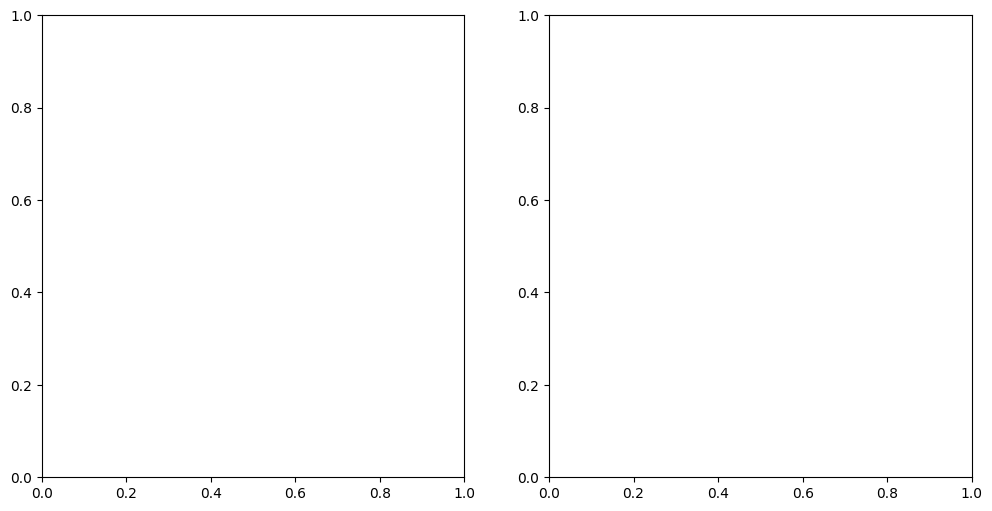

In [21]:
# Create a figure with two subplots

# Load the data
# train_errors = np.load(os.path.join(path, f'train_errors_operator_{t_string}.npy'))
# val_errors = np.load(os.path.join(path, f'val_errors_parametric_operator_{t_string}.npy'))


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the training error
axes[0].plot(np.arange(len(train_errors)) + 1, train_errors)
axes[0].set_yscale('log')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Error')
axes[0].set_title('Training Error (log)')

# Plot the validation error
axes[1].plot((np.arange(len(val_errors)) + 1), val_errors)
axes[1].set_xlabel('Time (s)')
axes[1].set_yscale('log')
axes[1].set_ylabel('Validation Error')
axes[1].set_title('Validation Error (log)')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [27]:
#Evaluate on the test set (Load the best model)
fno.load_state_dict(torch.load(save_path))
fno = fno.to(device)

start_time = time.time()
with torch.no_grad():
    fno.eval()
    test_loss = 0.0
    # test_relative_l2 = 0.0
    for step, (input_batch, output_batch) in enumerate(testing_set):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_rel = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
        loss_mse = torch.mean((output_pred_batch - output_batch) ** 2)
        # test_relative_l2 += loss_rel.item()
        test_loss += loss_mse.item()
    #test_relative_l2 /= len(testing_set)
    test_loss /= len(testing_set)

end_time = time.time()
prediction_time = end_time - start_time
print(f"Total prediction time: {prediction_time} seconds")

print(f"Total Test Error (MSE): {test_loss}")
print(f"Total log Test Error (MSE): {np.log(test_loss)}")


Total prediction time: 0.012686729431152344 seconds
Total Test Error (MSE): 4.0938240999821573e-05
Total log Test Error (MSE): -10.10344594397362


In [28]:
# Evaluate on the test set (Load the best model)
fno.load_state_dict(torch.load(save_path))
fno = fno.to(device)

start_time = time.time()

with torch.no_grad():
    fno.eval()
    test_loss = 0.0
    total_true_values = []
    total_predicted_values = []
    for step, (input_batch, output_batch) in enumerate(testing_set):
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_mse = torch.mean((output_pred_batch - output_batch) ** 2)
        test_loss += loss_mse.item()
        total_true_values.append(output_batch.cpu().numpy())
        total_predicted_values.append(output_pred_batch.cpu().numpy())
    test_loss /= len(testing_set)

# Compute total variance and total relative error
total_true_values = np.concatenate(total_true_values)
total_predicted_values = np.concatenate(total_predicted_values)
total_variance = np.var(total_true_values)
total_relative_error = test_loss / total_variance if total_variance != 0 else test_loss

end_time = time.time()
prediction_time = end_time - start_time
print(f"Total prediction time: {prediction_time} seconds")

print(f"Total Test Error (MSE): {test_loss}")
print(f"Total log Test Error (MSE): {np.log(test_loss)}")
print(f"Total Test Relative Error: {total_relative_error}")
print(f"Total log Test Relative Error: {np.log(total_relative_error)}")


Total prediction time: 0.014248132705688477 seconds
Total Test Error (MSE): 4.0938240999821573e-05
Total log Test Error (MSE): -10.10344594397362
Total Test Relative Error: 0.03561940839805612
Total log Test Relative Error: -3.334864609959948


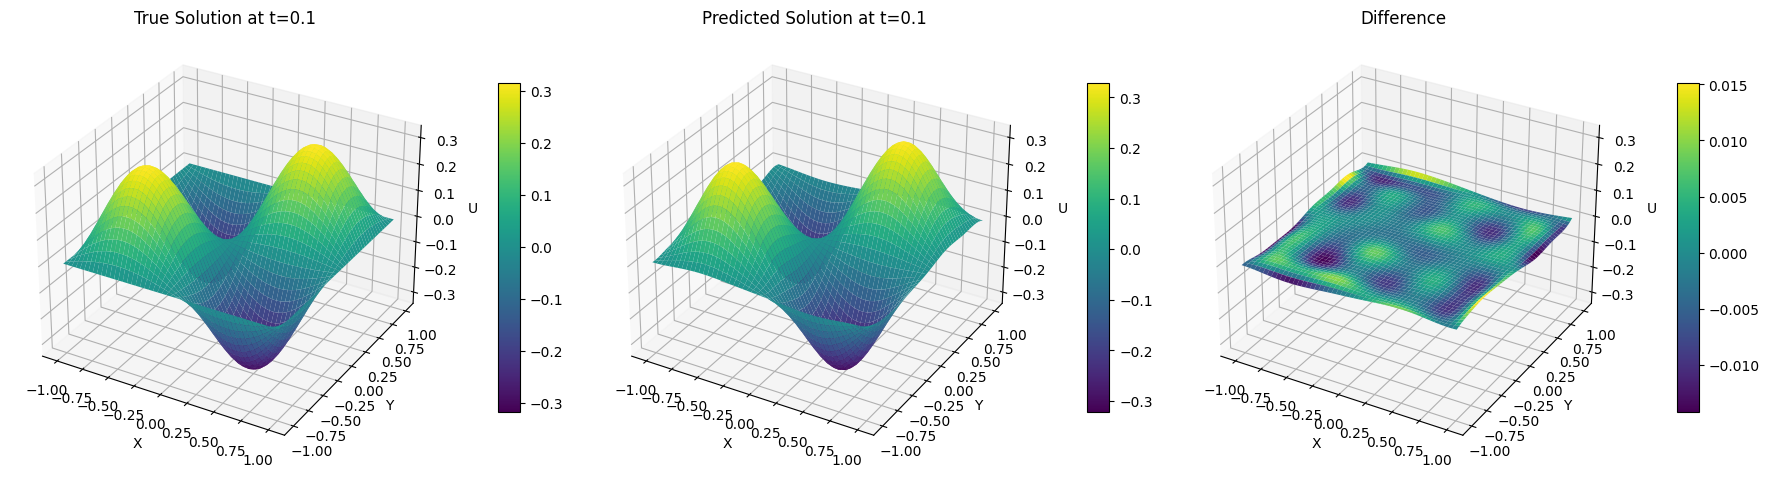

In [9]:
# Plot the initial condition and the solution
idx_data = 0
input_function_test_n = test_inputs[idx_data, :].unsqueeze(0)
output_function_test_n = test_outputs[idx_data, :].unsqueeze(0).cpu().numpy()
output_function_test_pred_n = fno(input_function_test_n).detach().cpu().numpy()

# Define the domain
x1 = np.linspace(-1, 1, n_points)
x2 = np.linspace(-1, 1, n_points)
X, Y = np.meshgrid(x1, x2)

output_test = output_function_test_n[0].squeeze()
output_pred = output_function_test_pred_n[0].squeeze()
difference = output_test - output_pred

# Compute the range for the z-axis
z_min = min(np.min(output_test), np.min(output_pred))
z_max = max(np.max(output_test), np.max(output_pred))
z_range = max(abs(z_min), abs(z_max))


fig = plt.figure(figsize=(18, 5))

# Plot the true solution
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
surf1 = ax1.plot_surface(X, Y, output_function_test_n[0].squeeze(), cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('U')
ax1.set_title('True Solution at t=0.1')
ax1.set_zlim([-z_range, z_range])
fig.colorbar(surf1, ax=ax1, shrink=0.7, aspect=15, pad=0.1)

# Plot the predicted solution
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
surf2 = ax2.plot_surface(X, Y, output_function_test_pred_n[0].squeeze() , cmap='viridis')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('U')
ax2.set_title('Predicted Solution at t=0.1')
ax2.set_zlim([-z_range, z_range])
fig.colorbar(surf2, ax=ax2, shrink=0.7, aspect=15, pad=0.1)

# Plot the difference
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
surf3 = ax3.plot_surface(X, Y, difference, cmap='viridis')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('U')
ax3.set_title('Difference')
ax3.set_zlim([-z_range, z_range])
fig.colorbar(surf3, ax=ax3, shrink=0.7, aspect=15, pad=0.1)

plt.tight_layout()
plt.show()




# ax = fig.add_subplot(1, 3, 1, projection='3d')
# surf = ax.plot_surface(X, Y, output_function_test_n[0].squeeze(), cmap='viridis')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('U')
# ax.set_title('True Solution at t=0.1')
# ax.set_zlim([-z_range, z_range])


# ax = fig.add_subplot(1, 3, 2, projection='3d')
# surf = ax.plot_surface(X, Y, output_function_test_pred_n[0].squeeze(), cmap='viridis')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('U')
# ax.set_title('Predicted Solution at t=0.1')
# ax.set_zlim([-z_range, z_range])

# # Plot the difference as a 2D heatmap
# ax = fig.add_subplot(1, 3, 3)
# heatmap = ax.imshow(difference, cmap='viridis', origin='lower', extent=[-1, 1, -1, 1], vmin=-0.1, vmax=0.1)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_title('Difference ')
# plt.colorbar(heatmap)
# fig.subplots_adjust(wspace=0.3)


# ax = fig.add_subplot(1, 3, 3, projection='3d')
# surf = ax.plot_surface(X, Y, difference, cmap='viridis')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('U')
# ax.set_title('Difference')
# ax.set_zlim([-z_range, z_range])


# plt.tight_layout()
# plt.show()


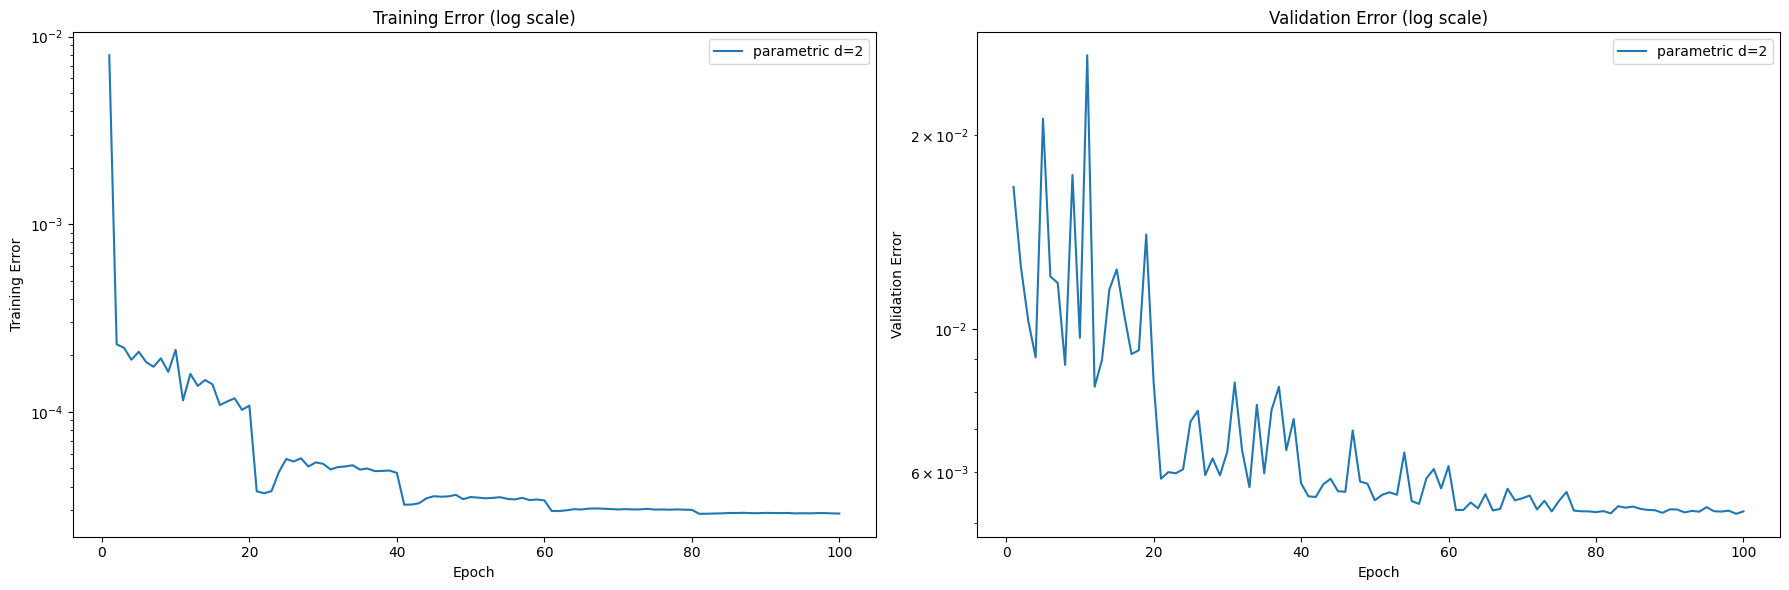

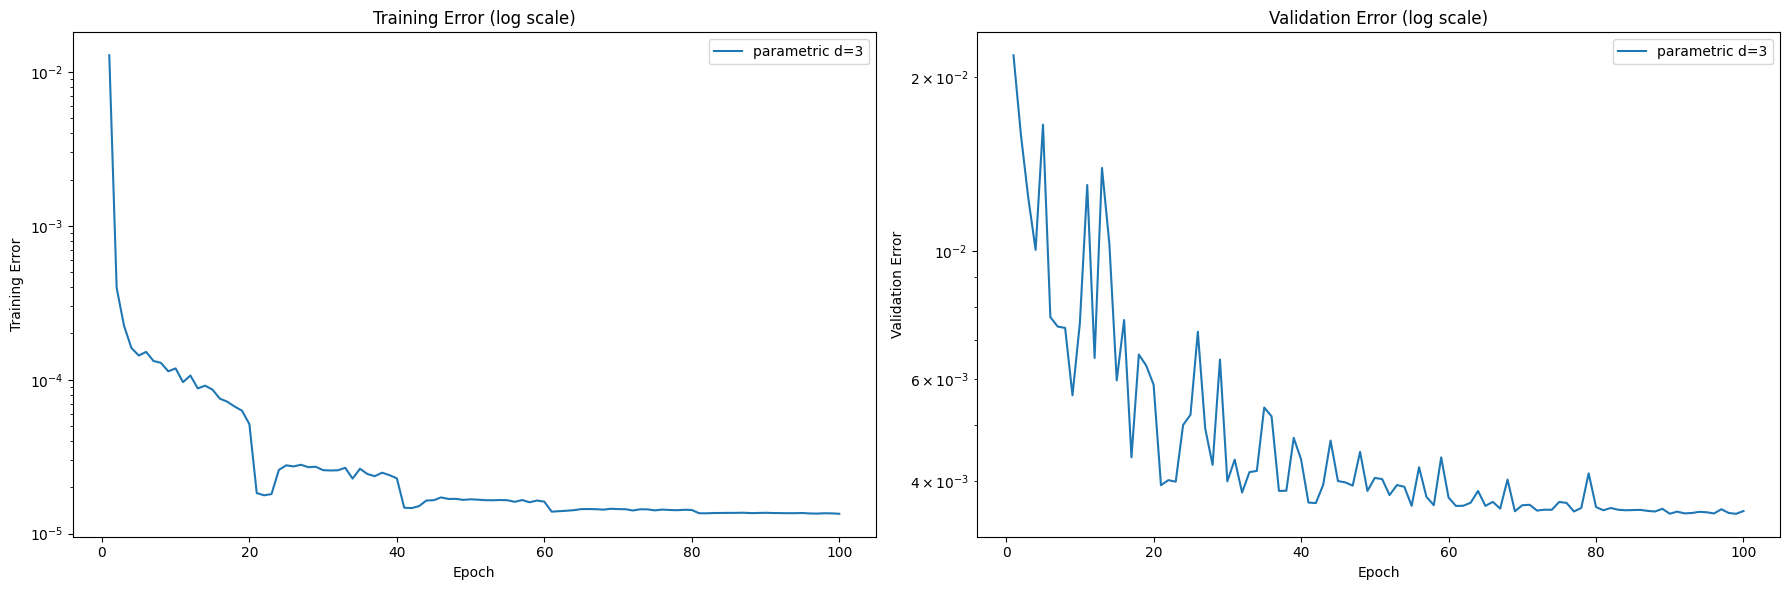

FileNotFoundError: ignored

In [15]:
import os
import matplotlib.pyplot as plt
import numpy as np

def t_to_string(t, N, dim):
    str_t = "{:.3f}".format(t)
    str_t = str_t.replace(".", "_")
    str_t = str_t.zfill(6)
    str_N = str(N).zfill(4)  # Assumes N is less than 10,000
    str_dim = str(dim)
    return str_t + "_" + str_N + "_" + str_dim

def load_errors(path, model_type, t_string):
    # Load the training and validation errors from the given path
    train_errors = np.load(os.path.join(path, f'train_errors_{model_type}_{t_string}.npy'))
    val_errors = np.load(os.path.join(path, f'val_errors_{model_type}_{t_string}.npy'))
    return train_errors, val_errors

def plot_errors(train_errors, val_errors, model_type, d):
    # Plot the training and validation errors
    epochs = np.arange(len(train_errors)) + 1

    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # Plot the training error
    axes[0].plot(epochs, train_errors, label=f'{model_type} d={d}')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Error')
    axes[0].set_yscale('log')
    axes[0].set_title('Training Error (log scale)')
    axes[0].legend()

    # Plot the validation error
    axes[1].plot(epochs, val_errors, label=f'{model_type} d={d}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Validation Error')
    axes[1].set_yscale('log')
    axes[1].set_title('Validation Error (log scale)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

T = 0.1
N_dataSamples = 1000
n_points = 50
path = '/content/drive/MyDrive/DLSC/projectB/heat/errors/'

# Define the model types and dimensions you want to load and plot
model_types = ['parametric', 'operator']
dimensions = [2, 3, 4]  # Adapt these as needed

# Load and plot the errors for each model type and dimension
for model_type in model_types:
    for d in dimensions:
        t_string = t_to_string(T, N_dataSamples, d)
        train_errors, val_errors = load_errors(path, model_type, t_string)
        plot_errors(train_errors, val_errors, model_type, d)
